<a href="https://colab.research.google.com/github/otakunoichin/test/blob/main/AI%E7%B6%B2%E8%86%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT = Path("/content/drive/MyDrive/ai_dataset")
IMG_DIR = ROOT / "images"
LBL_DIR = ROOT / "labels"

assert IMG_DIR.exists(), IMG_DIR
assert LBL_DIR.exists(), LBL_DIR

print("IMG_DIR:", IMG_DIR)
print("LBL_DIR:", LBL_DIR)

Mounted at /content/drive
IMG_DIR: /content/drive/MyDrive/ai_dataset/images
LBL_DIR: /content/drive/MyDrive/ai_dataset/labels


In [4]:
img_map = {p.stem: p for p in IMG_DIR.glob("*.jpg")}
lbl_map = {p.stem: p for p in LBL_DIR.glob("*.tif")}

common_ids = sorted(set(img_map) & set(lbl_map))
pairs = [(img_map[i], lbl_map[i]) for i in common_ids]

print("images:", len(img_map))
print("labels:", len(lbl_map))
print("paired :", len(pairs))
print("example ids:", common_ids[:10])


images: 20
labels: 35
paired : 20
example ids: ['001', '002', '004', '005', '006', '007', '011', '016', '024', '026']


img shape : (4000, 4000) dtype: uint8 min/max: 0 255
mask shape: (4000, 4000) dtype: uint8 unique (sample): [  0 255]


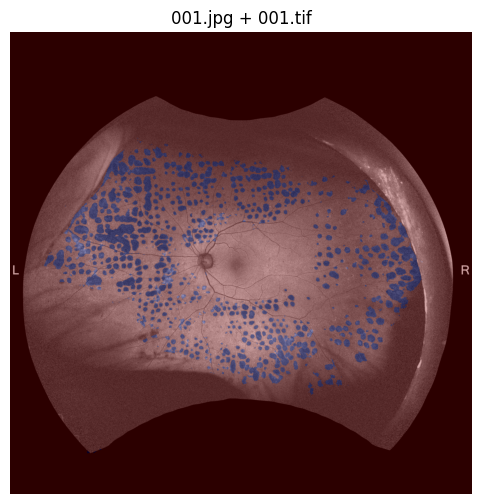

In [5]:
def read_gray(path: Path):
    # jpg/tif問わずグレースケールで読む
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"failed to read: {path}")
    return img

def show_overlay(img, mask, title="overlay"):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.35)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 先頭のペアで確認
img_path, mask_path = pairs[0]
img = read_gray(img_path)
mask = read_gray(mask_path)

print("img shape :", img.shape, "dtype:", img.dtype, "min/max:", img.min(), img.max())
print("mask shape:", mask.shape, "dtype:", mask.dtype, "unique (sample):", np.unique(mask)[:10])

# マスクを2値化（>0 を True）
mask_bin = (mask > 0).astype(np.uint8)

# サイズが違う場合は、とりあえず「表示用」にマスクを画像サイズへ
mask_for_vis = mask_bin
if mask_for_vis.shape != img.shape:
    mask_for_vis = cv2.resize(mask_for_vis, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

show_overlay(img, mask_for_vis, title=f"{img_path.name} + {mask_path.name}")

In [7]:
PATCH_ROOT = Path("/content/patches_512") # Changed to a local path
PATCH_IMG_DIR = PATCH_ROOT / "images"
PATCH_MSK_DIR = PATCH_ROOT / "masks"
PATCH_IMG_DIR.mkdir(parents=True, exist_ok=True)
PATCH_MSK_DIR.mkdir(parents=True, exist_ok=True)

TARGET = 4096
PATCH = 512
GRID = TARGET // PATCH  # 8

def reflect_pad_to(img, target=4096):
    h, w = img.shape[:2]
    assert h <= target and w <= target
    pad_h = target - h
    pad_w = target - w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(img, ((top, bottom), (left, right)), mode="reflect")

def make_patches_one(img, mask_bin, img_id: str):
    # img: uint8 gray, mask_bin: {0,1} uint8 gray
    img_p = reflect_pad_to(img, TARGET)
    msk_p = reflect_pad_to(mask_bin, TARGET)

    # パッチ切り出し
    count = 0
    for r in range(GRID):
        for c in range(GRID):
            y0, y1 = r*PATCH, (r+1)*PATCH
            x0, x1 = c*PATCH, (c+1)*PATCH
            ip = img_p[y0:y1, x0:x1]
            mp = msk_p[y0:y1, x0:x1]

            out_img = PATCH_IMG_DIR / f"image_{img_id}_row{r}_col{c}.png"
            out_msk = PATCH_MSK_DIR / f"mask_{img_id}_row{r}_col{c}.png"
            cv2.imwrite(str(out_img), ip)
            cv2.imwrite(str(out_msk), (mp*255).astype(np.uint8))
            count += 1
    return count

# 全ペアをパッチ化
total_patches = 0
for img_path, mask_path in pairs:
    img_id = img_path.stem  # "001" etc
    img = read_gray(img_path)
    mask = read_gray(mask_path)
    mask_bin = (mask > 0).astype(np.uint8)

    # ★重要：サイズが一致しない場合は「まず同じサイズに揃える」
    if mask_bin.shape != img.shape:
        mask_bin = cv2.resize(mask_bin, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    total_patches += make_patches_one(img, mask_bin, img_id)

print("total_patches:", total_patches)
print("expected per image:", 64, "=> expected total =", 64 * len(pairs))

total_patches: 1280
expected per image: 64 => expected total = 1280


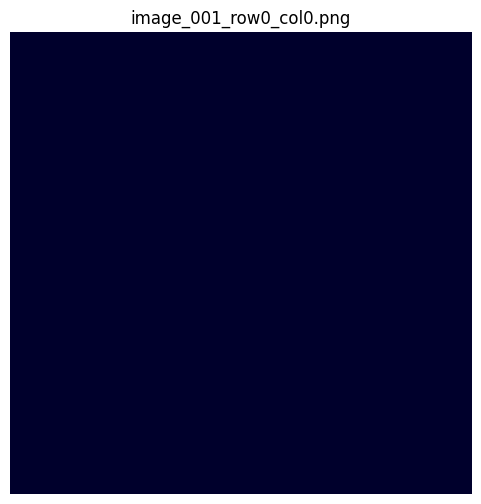

patch shape: (512, 512)


In [8]:
sample = sorted(PATCH_IMG_DIR.glob("*.png"))[0]
img = read_gray(sample)
msk = read_gray(PATCH_MSK_DIR / sample.name.replace("image_", "mask_"))
show_overlay(img, (msk>0).astype(np.uint8), title=sample.name)
print("patch shape:", img.shape)

In [9]:
import albumentations as A

# 推奨Augmentation（Word）
train_aug = A.Compose([
    A.RandomRotate90(p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
])

val_aug = A.Compose([])

def list_patch_pairs():
    imgs = sorted(PATCH_IMG_DIR.glob("*.png"))
    pairs = []
    for ip in imgs:
        mp = PATCH_MSK_DIR / ip.name.replace("image_", "mask_")
        if mp.exists():
            pairs.append((ip, mp))
    return pairs

patch_pairs = list_patch_pairs()
print("patch pairs:", len(patch_pairs))

train_pairs, val_pairs = train_test_split(patch_pairs, test_size=0.2, random_state=42)

class PatchSegDataset(Dataset):
    def __init__(self, pairs, aug=None):
        self.pairs = pairs
        self.aug = aug

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = read_gray(ip)  # [H,W] uint8
        msk = read_gray(mp)  # [H,W] uint8(0/255)
        msk = (msk > 0).astype(np.uint8)

        if self.aug is not None:
            out = self.aug(image=img, mask=msk)
            img, msk = out["image"], out["mask"]

        # 正規化してTensor化
        img_t = torch.from_numpy(img).float().unsqueeze(0) / 255.0  # (1,H,W)
        msk_t = torch.from_numpy(msk).float().unsqueeze(0)          # (1,H,W) 0/1
        return img_t, msk_t

train_ds = PatchSegDataset(train_pairs, aug=train_aug)
val_ds   = PatchSegDataset(val_pairs,   aug=val_aug)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

patch pairs: 1280


x shape: torch.Size([1, 512, 512]) y shape: torch.Size([1, 512, 512])
x min/max: 0.1921568661928177 0.7529411911964417
y unique: tensor([0., 1.])


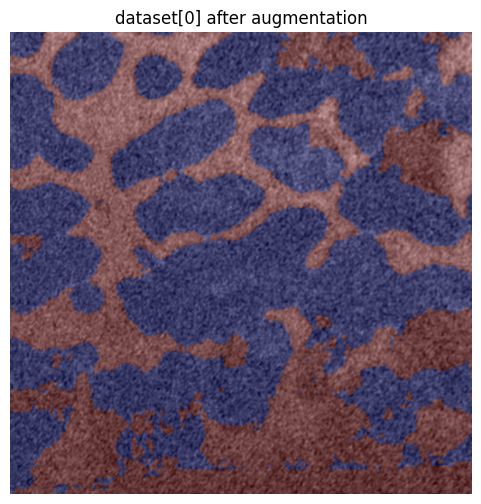

In [10]:
x, y = train_ds[0]
print("x shape:", x.shape, "y shape:", y.shape)   # (C,H,W) になってるか
print("x min/max:", x.min().item(), x.max().item())
print("y unique:", torch.unique(y))

# Aug後の対応がズレてないかを可視化
img = (x[0].numpy() * 255).astype(np.uint8)
msk = y[0].numpy().astype(np.uint8)
show_overlay(img, msk, title="dataset[0] after augmentation")

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool1(c1))
        c3 = self.down3(self.pool2(c2))
        c4 = self.down4(self.pool3(c3))

        bn = self.bottleneck(self.pool4(c4))

        u4 = self.up4(bn)
        d4 = self.dec4(torch.cat([u4, c4], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, c3], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, c1], dim=1))

        return self.outc(d1)  # logits

def dice_loss_with_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    dice = 1 - (num / den)
    return dice.mean()

bce = nn.BCEWithLogitsLoss()

def loss_fn(logits, targets):
    return bce(logits, targets) + dice_loss_with_logits(logits, targets)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

dummy = torch.randn(1, 1, 512, 512).to(device)
out = model(dummy)
print("dummy in :", dummy.shape)
print("dummy out:", out.shape)  # 同じ(1,1,512,512)か？

param_count = sum(p.numel() for p in model.parameters())
print("params:", param_count)

dummy in : torch.Size([1, 1, 512, 512])
dummy out: torch.Size([1, 1, 512, 512])
params: 7765409


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
BEST_PATH = "/content/unet_best.pth" # Changed to a local path

def dice_coef(pred_bin, target_bin, eps=1e-6):
    # pred_bin/target_bin: (N,1,H,W) 0/1
    inter = (pred_bin * target_bin).sum(dim=(2,3))
    den = pred_bin.sum(dim=(2,3)) + target_bin.sum(dim=(2,3)) + eps
    return (2*inter/den).mean().item()

train_losses, val_losses = [], []
train_dices, val_dices = [], []

best_val = 1e9
EPOCHS = 10

for epoch in range(EPOCHS):
    # ---- train ----
    model.train()
    tr_loss = 0
    tr_dice = 0
    n_tr = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item() * x.size(0)

        with torch.no_grad():
            pred = (torch.sigmoid(logits) > 0.5).float()
            tr_dice += dice_coef(pred, y) * x.size(0)
        n_tr += x.size(0)

    tr_loss /= n_tr
    tr_dice /= n_tr

    # ---- val ----
    model.eval()
    va_loss = 0
    va_dice = 0
    n_va = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            va_loss += loss.item() * x.size(0)
            pred = (torch.sigmoid(logits) > 0.5).float()
            va_dice += dice_coef(pred, y) * x.size(0)
            n_va += x.size(0)

    va_loss /= n_va
    va_dice /= n_va

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_dices.append(tr_dice);  val_dices.append(va_dice)

    # best save
    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), BEST_PATH)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} dice {tr_dice:.4f} | "
          f"val loss {va_loss:.4f} dice {va_dice:.4f} | best {best_val:.4f}")

print("saved best:", BEST_PATH)

Epoch 1/10 | train loss 0.5645 dice 0.9531 | val loss 0.5094 dice 0.9630 | best 0.5094
Epoch 2/10 | train loss 0.4956 dice 0.9563 | val loss 0.4334 dice 0.9693 | best 0.4334
Epoch 3/10 | train loss 0.4372 dice 0.9603 | val loss 0.3740 dice 0.9696 | best 0.3740
Epoch 4/10 | train loss 0.4003 dice 0.9606 | val loss 0.3017 dice 0.9713 | best 0.3017
Epoch 5/10 | train loss 0.3611 dice 0.9617 | val loss 0.2906 dice 0.9722 | best 0.2906
Epoch 6/10 | train loss 0.3288 dice 0.9631 | val loss 0.3154 dice 0.9683 | best 0.2906
Epoch 7/10 | train loss 0.3013 dice 0.9657 | val loss 0.2776 dice 0.9668 | best 0.2776
Epoch 8/10 | train loss 0.2800 dice 0.9655 | val loss 0.2393 dice 0.9713 | best 0.2393
Epoch 9/10 | train loss 0.2463 dice 0.9683 | val loss 0.2099 dice 0.9758 | best 0.2099
Epoch 10/10 | train loss 0.2347 dice 0.9685 | val loss 0.2222 dice 0.9664 | best 0.2099
saved best: /content/unet_best.pth


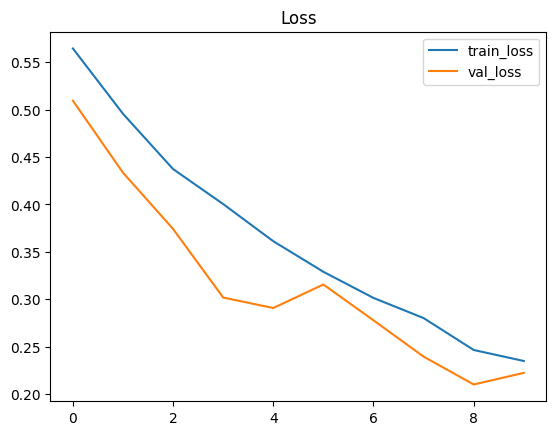

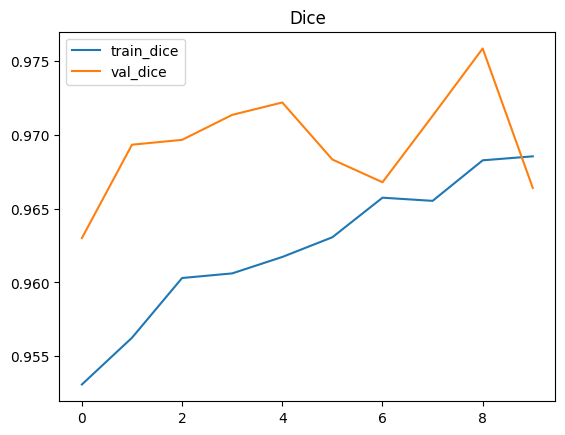

In [15]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(); plt.title("Loss"); plt.show()

plt.figure()
plt.plot(train_dices, label="train_dice")
plt.plot(val_dices, label="val_dice")
plt.legend(); plt.title("Dice"); plt.show()

input: (4000, 4000) output: (4000, 4000) unique: [0 1]


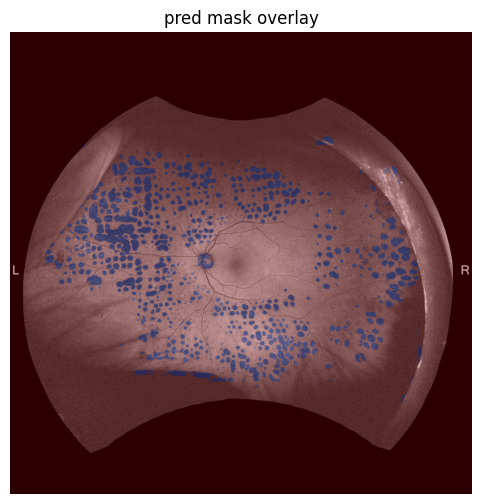

In [16]:
# best model load
model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.eval()

def pad_to_4096_reflect(img_4000):
    return reflect_pad_to(img_4000, 4096)

def predict_full_mask(img_4000):
    """
    img_4000: [H,W] uint8 (理想は4000x4000)
    return: pred_mask_4000 uint8 (0/1)
    """
    h, w = img_4000.shape
    img_p = pad_to_4096_reflect(img_4000)  # 4096
    pred_p = np.zeros((4096,4096), dtype=np.uint8)

    with torch.no_grad():
        for r in range(GRID):
            for c in range(GRID):
                y0, y1 = r*PATCH, (r+1)*PATCH
                x0, x1 = c*PATCH, (c+1)*PATCH
                patch = img_p[y0:y1, x0:x1]

                x = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0) / 255.0
                x = x.to(device)
                logits = model(x)
                prob = torch.sigmoid(logits)[0,0].cpu().numpy()
                binm = (prob > 0.5).astype(np.uint8)
                pred_p[y0:y1, x0:x1] = binm

    # crop back to original size (中心cropではなく、reflect_padの中央に元画像がある前提)
    # reflect_pad_to は上下左右に均等配分で足しているので、同じ計算でcrop位置を出す
    pad_h = 4096 - h
    pad_w = 4096 - w
    top = pad_h // 2
    left = pad_w // 2
    pred_4000 = pred_p[top:top+h, left:left+w]
    return pred_4000

# テスト推論（1枚）
test_img_path, _ = pairs[0]
img = read_gray(test_img_path)
pred = predict_full_mask(img)

print("input:", img.shape, "output:", pred.shape, "unique:", np.unique(pred))
show_overlay(img, pred, title="pred mask overlay")

instances: 836


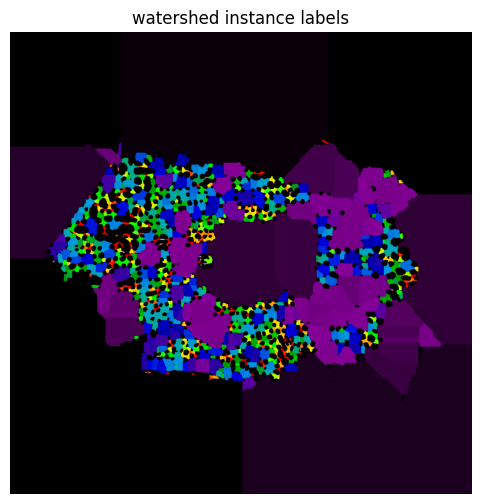

In [17]:
def watershed_instances(mask_bin, min_distance=10, threshold_abs=3):
    """
    mask_bin: 0/1 uint8
    return: labels (int32) 0=背景, 1..N=凝固斑ID
    """
    distance = distance_transform_edt(mask_bin)

    coords = peak_local_max(
        distance,
        min_distance=min_distance,
        threshold_abs=threshold_abs,
        labels=mask_bin
    )

    markers = np.zeros_like(mask_bin, dtype=np.int32)
    for i, (r, c) in enumerate(coords, start=1):
        markers[r, c] = i

    labels = watershed(-distance, markers, mask=mask_bin)
    return labels

inst = watershed_instances(pred, min_distance=10, threshold_abs=3)
print("instances:", inst.max())

# 可視化（輪郭っぽく見せる）
plt.figure(figsize=(6,6))
plt.imshow(inst, cmap="nipy_spectral")
plt.title("watershed instance labels")
plt.axis("off")
plt.show()

In [18]:
for md in [5, 10, 15]:
    inst_md = watershed_instances(pred, min_distance=md, threshold_abs=3)
    print("min_distance", md, "=> instances", inst_md.max())

min_distance 5 => instances 1239
min_distance 10 => instances 836
min_distance 15 => instances 676


In [19]:
def extract_features(instance_labels, img_gray):
    props = regionprops(instance_labels, intensity_image=img_gray)
    rows = []
    for p in props:
        rows.append({
            "label": p.label,
            "centroid_y": float(p.centroid[0]),
            "centroid_x": float(p.centroid[1]),
            "area": int(p.area),
            "mean_intensity": float(p.mean_intensity),
            "eccentricity": float(p.eccentricity),
        })
    return pd.DataFrame(rows)

df = extract_features(inst, img)
df.head(), df.shape

(   label   centroid_y   centroid_x     area  mean_intensity  eccentricity
 0      1  3220.117306   840.138005  2871803       39.460653      0.762344
 1      2   638.675737  3417.311913  1566103       15.414295      0.558162
 2      3   497.697021   481.659855   957349        5.963996      0.258977
 3      4   557.800227  1861.913813  1994892       27.343277      0.768616
 4      5   554.500000  2000.000000     1090       20.558716      1.000000,
 (836, 6))

In [22]:
OUT_CSV = f"/content/features_{test_img_path.stem}.csv" # Changed to a local path
df.to_csv(OUT_CSV, index=False)
print("saved:", OUT_CSV)

saved: /content/features_001.csv


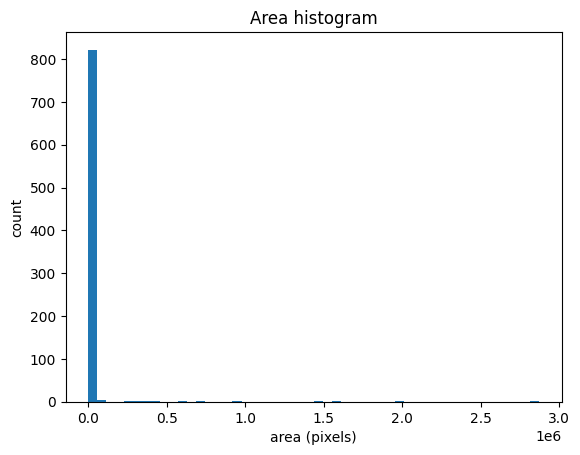

In [23]:
plt.figure()
plt.hist(df["area"], bins=50)
plt.title("Area histogram")
plt.xlabel("area (pixels)")
plt.ylabel("count")
plt.show()

In [24]:
def seg_metrics(pred_bin, gt_bin, eps=1e-6):
    pred = pred_bin.astype(np.uint8)
    gt   = gt_bin.astype(np.uint8)

    tp = np.logical_and(pred==1, gt==1).sum()
    fp = np.logical_and(pred==1, gt==0).sum()
    fn = np.logical_and(pred==0, gt==1).sum()

    dice = (2*tp) / (2*tp + fp + fn + eps)
    iou  = tp / (tp + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    return {"dice": dice, "iou": iou, "precision": prec, "recall": rec}